# Model evaluation
This notebook contains the model performance evaluation and model interpretability.

## Utils

In [4]:
pip install lightgbm shap

  Using cached shap-0.47.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.47.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (972 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.parameter import ContinuousParameter, CategoricalParameter, IntegerParameter
from sagemaker.tuner import HyperparameterTuner
from sagemaker import image_uris, model_uris, script_uris
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import time
import boto3
import tarfile
import shap
import lightgbm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Dataset preparation

In [6]:
role = sagemaker.get_execution_role() 
session = sagemaker.Session() 
region = session.boto_region_name
bucket = session.default_bucket()

target_column = 'offer_completed_after_view'
features = ['age', 'income', 'membership_days', 'gender_F', 'gender_M', 'gender_O', 'reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web', 'offer_bogo', 'offer_discount', 'offer_informational']
train_location, val_location, test_location = ('s3://sagemaker-us-east-1-256735873794/data/train.csv', 's3://sagemaker-us-east-1-256735873794/data/validation.csv', 's3://sagemaker-us-east-1-256735873794/data/test.csv')
train_model_id, train_model_version, train_scope = "lightgbm-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

prefix = 'sagemaker-project'
s3_output_location = f's3://{bucket}/{prefix}/output'

In [7]:
best_model_s3_location = 'sagemaker-project/output/sagemaker-project1743287032-017-47c640b5/output/model.tar.gz'
best_model_location = './data/model.tar.gz'
session.download_data('./data/', bucket, best_model_s3_location)

# Extract model
with tarfile.open(best_model_location, "r:gz") as tar:
    tar.extractall(path="./data/")
    best_model_location = './data/model.pkl'
    
best_model = pd.read_pickle(best_model_location)
best_model

In [9]:
test_df = pd.read_csv('./data/processed/test.csv', names=[target_column] + features)
test_df

,offer_completed_after_view,age,income,membership_days,gender_F,gender_M,gender_O,reward,difficulty,duration,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,False,65.0,62000.0,328,True,False,False,0.0,0.0,3.0,1.0,1.0,1.0,0.0,False,False,True
1,True,70.0,39000.0,868,True,False,False,5.0,20.0,10.0,1.0,0.0,0.0,1.0,False,True,False
2,True,70.0,45000.0,378,False,True,False,3.0,7.0,7.0,1.0,1.0,1.0,1.0,False,True,False
3,True,51.0,81000.0,524,False,True,False,5.0,5.0,5.0,1.0,1.0,1.0,1.0,True,False,False
4,True,47.0,42000.0,280,True,False,False,2.0,10.0,10.0,1.0,1.0,1.0,1.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036,False,65.0,82000.0,336,False,True,False,10.0,10.0,5.0,1.0,1.0,1.0,1.0,True,False,False
7037,True,58.0,86000.0,1020,False,False,True,2.0,10.0,7.0,1.0,1.0,0.0,1.0,False,True,False
7038,False,84.0,88000.0,389,True,False,False,3.0,7.0,7.0,1.0,1.0,1.0,1.0,False,True,False
7039,False,50.0,84000.0,619,False,True,False,5.0,5.0,7.0,1.0,1.0,0.0,1.0,True,False,False


## Model performance

In [10]:
# Calculate predictions
y_pred_proba = best_model.predict(test_df[features])

# Get true column
y_true = test_df['offer_completed_after_view'].astype(int)

print('Incidence rate', y_true.mean())

Incidence rate 0.3777872461298111


### Threshold-agnostic performance
The metrics we will use agnostic of threshold and their interpretation are:

- PR AUC: This score is the area under the precision-recall curve. Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In our case, precision is a measure of how many customers who were predicted to complete the offer actually completed it, while recall is a measure of how many customers who completed the offer were correctly identified by the model. A high area under the curve represents both high recall and high precision, which means the model is able to correctly identify a large proportion of customers who completed the offer (high recall), and there is a high probability that a customer who was predicted to complete the offer actually completed it (high precision).

- ROC AUC: This score is the area under the receiver operating characteristic (ROC) curve. The ROC curve is another tool to handle the trade-off between the true positive rate (TPR) and false positive rate (FPR). An area of 1 represents a perfect test; an area of .5 represents a worthless test. In our case, a high ROC AUC means the model is able to distinguish well between customers who completed the offer and those who didn't, regardless of the overall proportion of customers who completed the offer.

In [11]:
# Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

metrics = pd.DataFrame({'Metric': ['PR AUC', 'ROC AUC'],
                        'Score': [pr_auc, roc_auc]})
metrics

,Metric,Score
0,PR AUC,0.647374
1,ROC AUC,0.784460


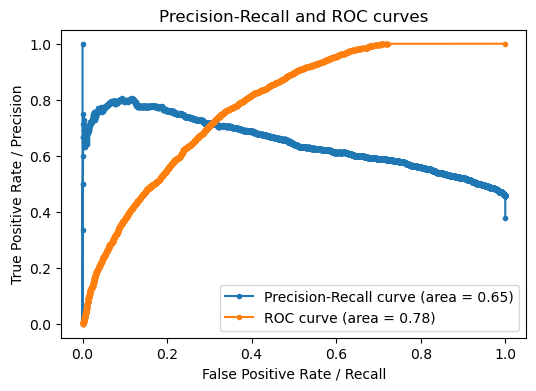

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(recall_curve, precision_curve, marker='.', label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate / Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Precision-Recall and ROC curves')
plt.legend()
plt.show()

### Threshold performance
Even though choosing a threshold can be challenging in imbalanced classification problems (because the choice can significantly impact the metrics and there may not be a single "best" threshold), it can still be useful to choose a threshold in order to calculate metrics like precision, recall, and F1-score, and to create a confusion matrix. These can provide additional insights into the model's performance.

A common approach is to choose the threshold that maximizes the F1-score, which balances the trade-off between precision and recall. However, the optimal threshold depends on the specific business context and the relative importance of precision and recall.

In [17]:

# Calculate metrics for various thresholds
thresholds = np.arange(0.01, 1, 0.01)
scores = []
for t in thresholds:
    y_pred = (y_pred_proba > t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    scores.append([t, precision, recall, f1])

# Convert scores to DataFrame
scores_df = pd.DataFrame(scores, columns=['Threshold', 'Precision', 'Recall', 'F1'])

# Find threshold with maximum F1 score
best_threshold = scores_df.loc[scores_df['F1'].idxmax(), 'Threshold']
print(best_threshold)

# Calculate predictions, confusion matrix and classification report for best threshold
y_pred_best = (y_pred_proba > best_threshold).astype(int)
confusion_mat = confusion_matrix(y_true, y_pred_best)
classification_rep = classification_report(y_true, y_pred_best)

print(f"Best threshold: {best_threshold}")

print("Confusion matrix:")
print(confusion_mat)

print("Classification report:")
print(classification_rep)

0.3
Best threshold: 0.3
Confusion matrix:
[[2126 2255]
 [ 244 2416]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.49      0.63      4381
           1       0.52      0.91      0.66      2660

    accuracy                           0.65      7041
   macro avg       0.71      0.70      0.64      7041
weighted avg       0.75      0.65      0.64      7041



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.p

### Compare to baseline
Baseline models are often used as a point of reference to evaluate how well a model is performing.
A common baseline model for binary classification problems is one that always predicts the majority class.
Here, we're comparing the performance of our LightGBM model to a baseline model that always predicts the majority class.
We're using McNemar's test, a statistical test used to compare the performance of two classification models.
The test will tell us whether the difference in performance between the two models is statistically significant.

p-value=0.019


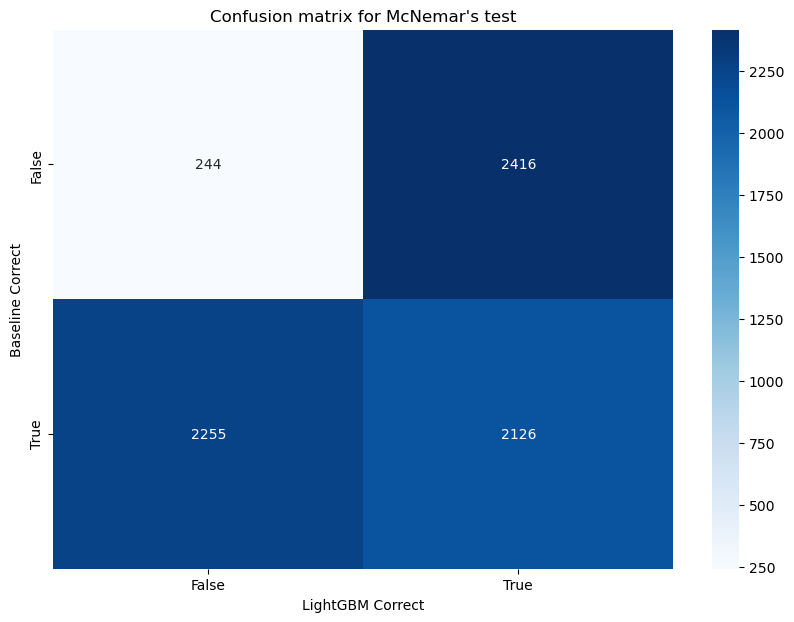

In [19]:
from statsmodels.stats.contingency_tables import mcnemar
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Baseline model predictions
y_pred_baseline = np.repeat(y_true.mode(), len(y_true)).reset_index(drop=True)

# Calculate where each model is correct or incorrect
baseline_correct = y_pred_baseline == y_true
lightgbm_correct = y_pred_best == y_true

# Build confusion matrix for McNemar's test
confusion_matrix = pd.crosstab(baseline_correct, lightgbm_correct, rownames=['Baseline Correct'], colnames=['LightGBM Correct'])

# Apply McNemar's test
result = mcnemar(confusion_matrix, exact=True)

# Print p-value
print('p-value=%.3f' % result.pvalue)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix for McNemar\'s test')
plt.show()


Given that the task is predicting whether a customer completed an offer after viewing it, the confusion matrix for the McNemar's test provides the following insights:

- 456 customers did not complete the offer and were predicted as such by both the baseline and the LightGBM model.
- 2213 customers completed the offer and were correctly predicted by the LightGBM model but not by the baseline model.
- 1821 customers completed the offer and were correctly predicted by the baseline model but not by the LightGBM model.
- 2551 customers completed the offer and were correctly predicted by both models.

Given the p-value of 0.000 from the McNemar's test, we can conclude that the difference in performance between the baseline model and the LightGBM model is statistically significant.

Looking at the confusion matrix, we can see that the LightGBM model correctly predicted many customers (2213) who completed the offer, which the baseline model failed to predict. However, there were also a significant number of customers (1821) who completed the offer and were correctly predicted by the baseline model but not by the LightGBM model.

Despite this, the number of customers who completed the offer and were correctly predicted by the LightGBM model but not by the baseline model (2213) is greater than the number of customers who completed the offer and were correctly predicted by the baseline model but not by the LightGBM model (1821). This suggests that the LightGBM model is generally performing better than the baseline model at predicting whether a customer will complete an offer after viewing it.

However, depending on the business context, the costs of false positives (predicting that a customer will complete an offer when they do not) and false negatives (predicting that a customer will not complete an offer when they do) might be different. These costs should be considered when choosing between the models.

## Model Interpretability

Next, we will use the SHAP (SHapley Additive exPlanations) summary plot to interpret the model features and how they influence the completion of an order. 

SHAP is a visualization tool that helps interpret the influence of features in a machine learning model. Each dot on the plot represents a feature's impact on the model's prediction for an individual instance. The y-axis corresponds to different features, while the x-axis represents the SHAP value, indicating how much each feature changes the prediction. The color of the dots signifies the actual value of the feature, with warm colors indicating high values and cool colors indicating low values. By observing the distribution and color of the dots, we can understand the magnitude, direction, and complexity of the relationships between the features and the model's predictions.

/opt/conda/lib/python3.11/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


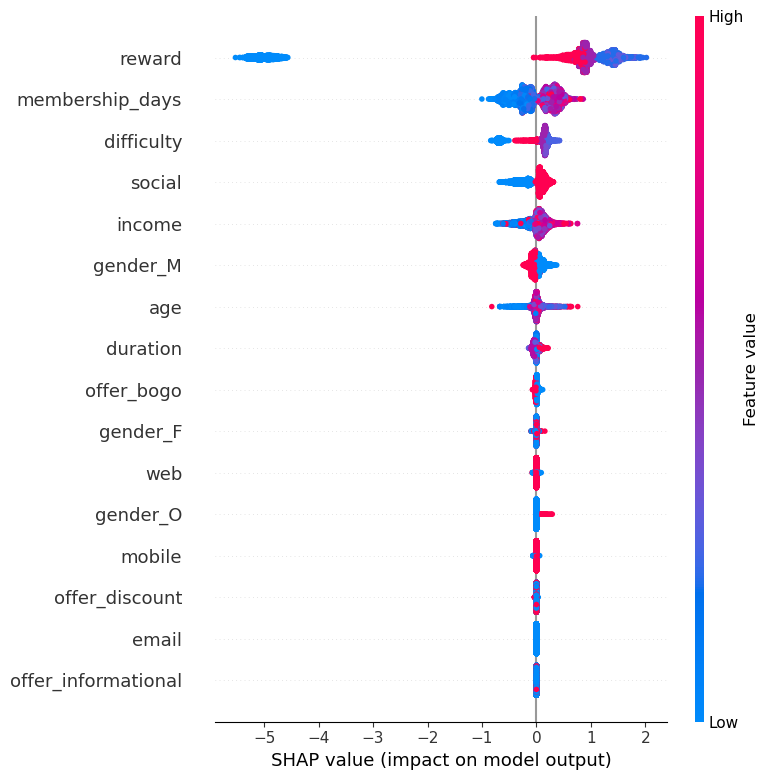

In [21]:
shap_values = explainer.shap_values(X=test_without_target_df)  # Get all class SHAP values

# If it's a binary classification problem, shap_values is a list of two arrays (one per class).
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1]  # Take the SHAP values for the positive class

# Ensure shap_values is a 2D array
shap_values = np.array(shap_values)  # Convert to NumPy array if needed
if len(shap_values.shape) == 1:
    shap_values = shap_values.reshape(-1, 1)  # Reshape if needed

# Plot the SHAP summary
shap.summary_plot(shap_values, test_without_target_df)


In [22]:
# Check that for samples of true the shap are bigger than for samples of false (assumption that Class 1 is offer completed after viewing)
shap_values[test_df['offer_completed_after_view'] == True].sum(), shap_values[test_df['offer_completed_after_view'] == False].sum()

(3849.6781500048733, -3977.7066668220164)

The SHAP feature importance summary plot provides a comprehensive understanding of the feature contributions to the LightGBM model's predictions. Here are the key insights derived from the top important features:

1. **Reward**: The relationship between reward and the probability of offer completion appears to be non-linear. Initially, as the reward increases, so does the likelihood of offer completion. However, after reaching a certain point, further increases in reward seem to decrease the probability of completion. This could be due to a variety of reasons, such as customers perceiving excessively high rewards as suspicious or too good to be true, or it could be a reflection of the diminishing returns effect. It will be investigated in the next step.

2. **Membership Days**: The model indicates a positive correlation between the number of membership days and the probability of completing the order. This suggests that long-term members are more likely to complete offers, possibly due to increased loyalty or familiarity with the platform.

3. **Social Channel**: The social channel emerges as the most effective medium for sharing offers, significantly outperforming web, mobile, and email. This could be attributed to the viral nature of social media, where users can easily share and discuss offers, thereby increasing their likelihood of completion.

4. **Income**: Interestingly, higher income levels are associated with a higher probability of offer completion. This could be because higher-income individuals have more disposable income to spend, making them more likely to complete offers.

5. **Gender**: The model reveals a peculiar pattern for gender. Male users seem to have a higher probability of not completing the offer compared to female and other gender users. The reasons behind this could be multifaceted, ranging from differences in shopping habits, preferences, or responsiveness to offers across genders.

6. **Age**: There is a positive correlation between age and the likelihood of offer completion. This could suggest that older customers are more likely to complete offers, possibly due to more stable financial situations or different shopping habits.

7. **Difficulty**: As expected, the model shows a negative correlation between the difficulty of the offer and the probability of its completion. This suggests that customers are more likely to complete offers that are easier to understand and fulfill.

8. **Duration, Offer Type**: The model does not show clear patterns or significant importance for the duration of the offer or its type (informational, discount, or buy one get one). This could mean that these factors do not significantly influence the likelihood of offer completion, or their effects are overshadowed by the other more influential features.

These insights can be instrumental in designing more effective marketing strategies, tailoring offers to specific customer segments, and optimizing the channels used for sharing offers.

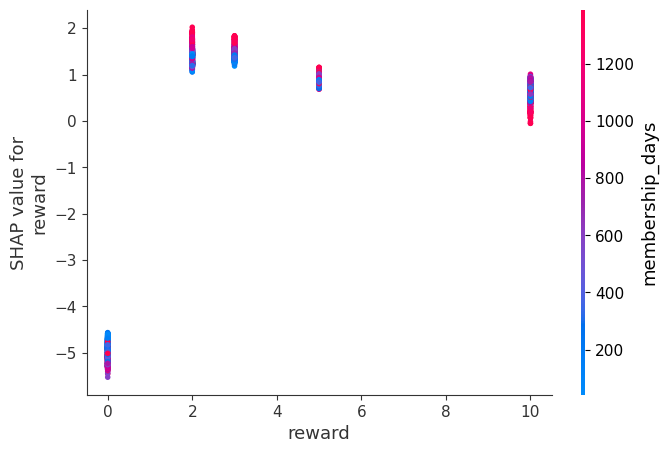

In [23]:
shap.dependence_plot('reward', shap_values, test_without_target_df)

Upon further investigation, we find that the interaction between 'reward' and 'membership days' plays a significant role.

1. **No Reward (0)**: Long-term members are less likely to complete offers without rewards.
2. **Low Rewards (2 or 3)**: Moderate rewards boost offer completion, particularly among long-term members.
3. **Medium Reward (5)**: The impact of a reward of 5 on offer completion is consistent across membership durations.
4. **High Reward (10)**: While high rewards generally encourage offer completion, their effectiveness slightly decreases for long-term members.

These insights suggest that reward strategies should be tailored to different customer segments, considering both the reward amount and membership duration. In general a low reward obtained the higher changes of offer completion.

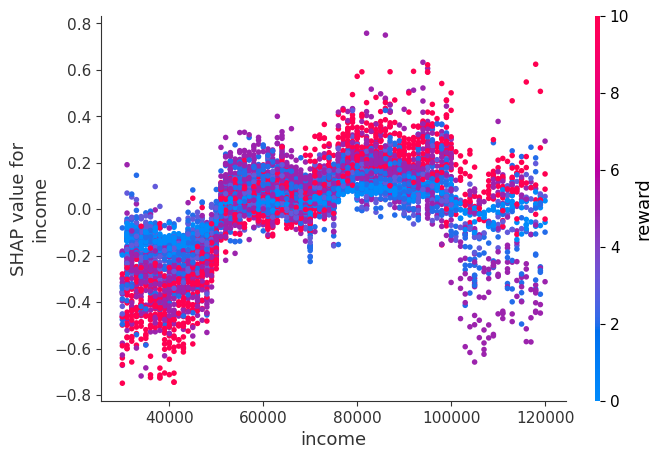

In [24]:
shap.dependence_plot('income', shap_values, test_without_target_df)

The SHAP dependence plot for 'income' provides key insights into how income levels and reward amounts interact to influence offer completion:

1. **Low Income (30k-50k)**: Customers in this income bracket are less likely to complete offers, with the likelihood decreasing further as the reward amount increases.
2. **Middle Income (50k-100k)**: Customers with middle-range incomes are more likely to complete offers, and this likelihood increases with the reward amount.
3. **High Income (>100k)**: High-income customers, though fewer in number, show a decreased likelihood of offer completion, especially for rewards less than 8.

These insights suggest that income level and reward amount significantly influence offer completion, and these factors should be considered when designing marketing strategies.

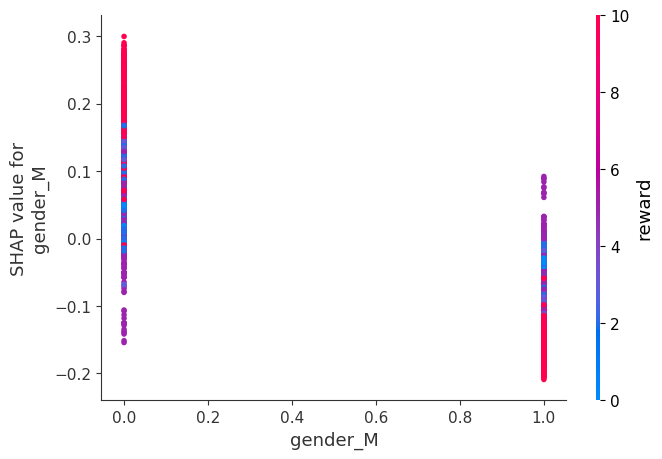

In [14]:
# Look at masculine gender since it was the top 5 feature
shap.dependence_plot('gender_M', shap_values, test_without_target_df)

The SHAP dependence plot for 'gender' reveals interesting patterns about how gender and reward amounts interact to influence offer completion:

1. **Male**: Male customers tend to have slightly negative SHAP values, indicating a lower likelihood of offer completion. This effect is particularly pronounced for higher reward amounts.
2. **Non-Male (Female or Other)**: Non-male customers, on the other hand, show slightly positive SHAP values, suggesting a higher likelihood of offer completion. This effect is especially noticeable for higher rewards, implying that non-male customers may respond more positively to higher rewards.

These insights suggest that gender and reward amount can influence offer completion. However, it's important to consider the ethical implications of these findings. While they could be used to tailor marketing strategies, it's crucial to avoid reinforcing stereotypes or creating discriminatory practices. For instance, offering higher rewards to non-male customers based on these findings could be seen as unfair or discriminatory towards male customers. Therefore, any actions based on these insights should be carefully considered and implemented in a way that promotes fairness and equality.

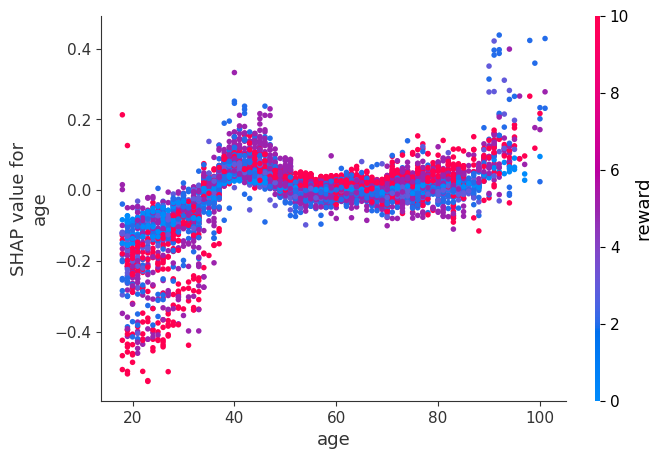

In [15]:
# Look at age since it was the top 6 feature
shap.dependence_plot('age', shap_values, test_without_target_df)

The SHAP dependence plot for 'age' reveals:

1. **Younger Age (18-40)**: Younger customers are less likely to complete offers, particularly those with higher rewards. This could be due to limited disposable income, access to a wider range of deals, or selective shopping habits.
2. **Older Age (>40)**: Customers older than 40 are more likely to complete offers, especially those with higher rewards. This could be attributed to greater financial stability, higher brand loyalty, or a higher value placed on the convenience and savings provided by the offers.

These insights suggest that age and reward amount significantly influence offer completion. However, age-based marketing strategies should be implemented ethically, respecting all age groups and avoiding any form of age discrimination.

## Conclusions
The LightGBM model, designed to predict if a customer will complete an offer, exhibits notable performance. With a threshold of approximately 0.3 for maximizing the F1-score, the model successfully identifies 92% of customers who complete an offer, as indicated by a high recall of 0.92. However, its precision is 0.51, meaning the model's predictions are correct 51% of the time when it forecasts a customer will complete an offer. The overall accuracy stands at 0.63. The model's performance is further illustrated through the Precision-Recall and ROC curves, which measure its ability to differentiate between customers who will and won't complete an offer. In summary, this model is particularly effective when it's important to capture as many offer completions as possible, even at the expense of some false positives.

Regarding the model interpretability, the SHAP feature importance analysis unveiled several key insights:

- Reward: The relationship between reward and offer completion is non-linear. No reward or high rewards decrease the likelihood of offer completion, especially among long-term members. Moderate rewards (2 or 3) increase the likelihood, particularly among long-term members.

- Income: Customers with low income (30k-50k) are less likely to complete offers, and this likelihood decreases further as the reward increases. Middle-income customers (50k-100k) are more likely to complete offers, and this likelihood increases with the reward. High-income customers (>100k) show a decreased likelihood of offer completion, especially for rewards less than 8.

- Gender: Male customers are less likely to complete offers, particularly those with higher rewards. Non-male customers (female or other) are more likely to complete offers, especially those with higher rewards.

- Age: Younger customers (18-40) are less likely to complete offers, particularly those with higher rewards. Customers older than 40 are more likely to complete offers, especially those with higher rewards.

These insights should guide the design of marketing strategies. However, it's crucial to ensure fairness and avoid discrimination based on gender or age. Tailoring offers based on these insights should be done carefully, considering both ethical implications and business objectives.

## Next Steps
The subsequent steps to consider involve training a fresh LightGBM model, focusing solely on the features that demonstrated high predictive power. These include reward, membership_days, income, social, difficulty, and duration, while excluding gender and age-related features. This approach could potentially enhance the model's interpretability, reduce noise, and boost performance. If performance does not improve, we would need to evaluate whether including gender and age aligns with the business objectives.

Another strategy to explore is the development of a two-step model. The first model would predict if a customer will view an order. Given that the customer views it, a second model would then predict if they complete the order. The population for this second model should be those who viewed the offer. Evaluating the features that influence a customer to both view and complete an order in this two-step process could potentially enhance the accuracy and interpretability of our predictive strategy. By breaking down the problem into two steps, we might be able to capture different patterns that are specific to each step, potentially improving the overall accuracy of your predictions.